In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.xception import preprocess_input  # Adjusted import for Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [2]:
# Check available GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Print information about each GPU
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Type:", gpu.device_type)
else:
    print("No GPU available, using CPU instead")


Name: /physical_device:GPU:0
Type: GPU


In [3]:
train_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/test/test'
img_size = (299, 299) 
batch_size = 16
epochs = 20
patience = 5


In [4]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 468 images belonging to 17 classes.


In [5]:
# Build the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) 

In [6]:
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Define the file name
file_name = 'models/xception_plant_disease_detection[01-04-2024].h5'

# Check if the file already exists
if os.path.exists(file_name):
    # Prompt the user to rename the file
    new_name = input("A file with the same name already exists. Please enter a new name: ")
    file_name = f"models/{new_name}.h5"
    print("New model name : ",file_name)

# Define callbacks
checkpoint = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)



In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping] 
)

Epoch 1/20
796/796 [==============================] - ETA: 0s - loss: 1.0855 - accuracy: 0.6531
Epoch 1: val_accuracy improved from -inf to 0.86565, saving model to models\xception_plant_disease_detection[17-03-2024].h5
796/796 [==============================] - 370s 454ms/step - loss: 1.0855 - accuracy: 0.6531 - val_loss: 0.4087 - val_accuracy: 0.8657
Epoch 2/20
796/796 [==============================] - ETA: 0s - loss: 0.6948 - accuracy: 0.7729
Epoch 2: val_accuracy improved from 0.86565 to 0.89024, saving model to models\xception_plant_disease_detection[17-03-2024].h5
796/796 [==============================] - 330s 415ms/step - loss: 0.6948 - accuracy: 0.7729 - val_loss: 0.3342 - val_accuracy: 0.8902
Epoch 3/20
796/796 [==============================] - ETA: 0s - loss: 0.5807 - accuracy: 0.8074
Epoch 3: val_accuracy improved from 0.89024 to 0.90151, saving model to models\xception_plant_disease_detection[17-03-2024].h5
796/796 [==============================] - 316s 396ms/step - los

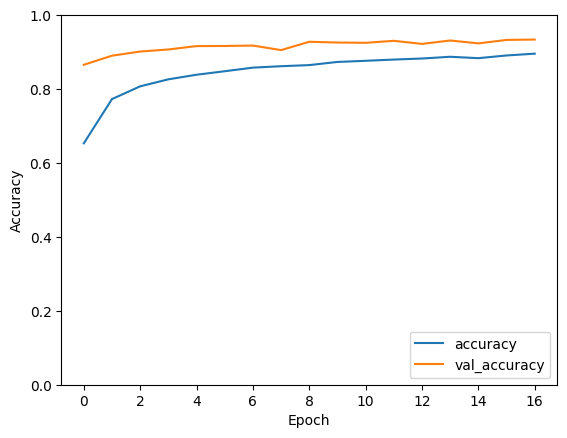

In [10]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [11]:
# Load model
#model = load_model('models/xception_plant_disease_detection.h5')

In [12]:
# Evaluate the model on test generator
test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)


C:\Users\Nabu\AppData\Local\Temp\ipykernel_22084\2128755816.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)


30/30 [==============================] - 7s 215ms/step - loss: 0.1374 - accuracy: 0.9444
Test Accuracy: 0.9444444179534912
Test Loss: 0.1373816281557083


In [13]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}


In [14]:
# Save class indices to a JSON file
with open('class_indices_xception.json', 'w') as f:
    json.dump(class_indices, f)

In [15]:
# Load class indices
with open('class_indices_xception.json', 'r') as f:
    class_indices = json.load(f)

# Load remedies
with open('remedies.json', 'r') as f:
    remedies= json.load(f)

In [16]:
# Function to predict disease from an image
def predict_disease(image_path):

    img = load_img(image_path, target_size=(img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)[0]
    predicted_class_index = np.argmax(prediction)
    disease = class_indices[str(predicted_class_index)]
    confidence = prediction[predicted_class_index]

    return disease, confidence 

In [17]:
image_path = 'D:/testproject/dataset/PlantDiseasesDataset/Apple/train/Apple Healthy/AppleHealthy(3).JPG' 

disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')

if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')

1/1 [==============================] - 1s 1s/step
Predicted Disease: Potato___Late_blight, Confidence: 0.6368938088417053
Remedies: Remedies for Potato Late Blight
